In [59]:
import gymnasium as gym
import minigrid

from __future__ import annotations

from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper


import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation
from IPython.display import HTML

# Create the Grid-World envrionment

## Approach 1

In this approach, the module is used to initialise the envrionent directly, from scratch

In [53]:
env = gym.make("MiniGrid-Empty-5x5-v0", render_mode="rgb_array")
observation, info = env.reset(seed=42)

manual_control = ManualControl(env, seed=42)

# Create a new grid
obs, info = env.reset()

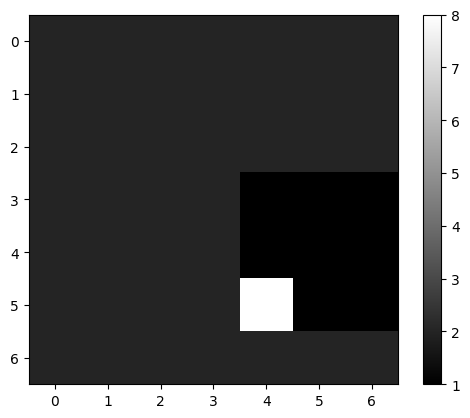

In [54]:
# This allows us to visualise the local grid
import matplotlib.pyplot as plt

plt.imshow(obs["image"][:, :, 0], cmap="gray")  # Show object types only
plt.colorbar()
plt.show()

(5, 5, 3)
[[ 2  2  2  2  2]
 [ 2 10  1  1  2]
 [ 2  1  1  1  2]
 [ 2  1  1  8  2]
 [ 2  2  2  2  2]]


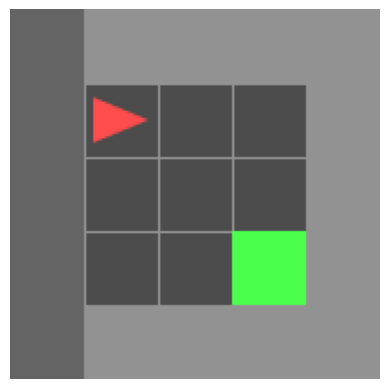

In [ ]:
# Instead if we want a picture of the entire grid on which the agent is acting
# we can use the FullyObsWrapper

env = FullyObsWrapper(gym.make("MiniGrid-Empty-5x5-v0"))
obs, info = env.reset()

print(obs['image'].shape)  # (5, 5, 3) - Full map
print(obs['image'][:, :, 0])  # (5, 5) - Object types

# However, using this mode the environment cannot be rendered because the 
# FullyObsWrapper modifies the observation space to provide the full grid observation
# and does not retain the rendering functionality of the original environment.

# To render the environment, you can use the base environment without the wrapper
base_env = gym.make("MiniGrid-Empty-5x5-v0", render_mode="rgb_array")
obs, info = base_env.reset()
plt.imshow(base_env.render())
plt.axis("off")
plt.show()

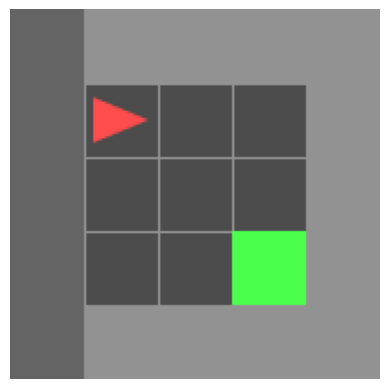

In [49]:
# Render and show the initial state
plt.imshow(env.render())
plt.axis("off")
plt.show()

## Approach 2

In this apporach, we build the envrionment from scratch is SimpleEnv inheriting from MiniGridEnv

In [7]:
class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=8,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            max_steps=256,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"
    
    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate vertical separation wall
        for i in range(0, height):
            self.grid.set(5, i, Wall())
        
        # Place the door and key
        self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
        self.grid.set(3, 6, Key(COLOR_NAMES[0]))

        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), width - 2, height - 2)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

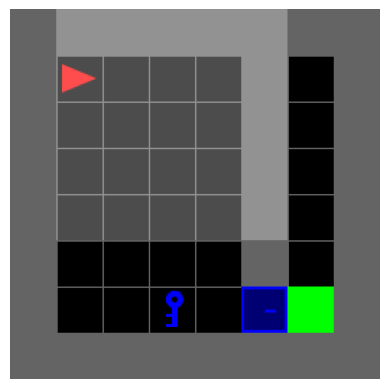

In [8]:
env = SimpleEnv(render_mode="rgb_array")

# enable manual control for testing
manual_control = ManualControl(env, seed=42)

env._gen_grid(8, 8)
env.reset()

# Render and show the initial state
plt.imshow(env.render())
plt.axis("off")
plt.show()

# Create an agent

To understand the basics, let's first create a random agent that takes random actions.

In [55]:
done = False
obs, info = env.reset()
frames = []

while not done:
    action = env.action_space.sample()  # Take a random action
    obs, reward, done, truncated, info = env.step(action)
    print(f"State: {obs['image'][:, :, 0]}, Action: {action}, Reward: {reward}, Done: {done}")
    
    # Store frames for visualization
    frames.append(env.render())

State: [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 1 1]
 [2 2 2 2 2 1 1]
 [2 2 2 2 2 8 1]
 [2 2 2 2 2 2 2]], Action: 2, Reward: 0, Done: False
State: [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 1 1]
 [2 2 2 2 2 1 1]
 [2 2 2 2 2 8 1]
 [2 2 2 2 2 2 2]], Action: 5, Reward: 0, Done: False
State: [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 1 1]
 [2 2 2 2 2 1 1]
 [2 2 2 2 2 8 1]
 [2 2 2 2 2 2 2]], Action: 6, Reward: 0, Done: False
State: [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 1 1]
 [2 2 2 2 2 1 1]
 [2 2 2 2 2 8 1]
 [2 2 2 2 2 2 2]], Action: 3, Reward: 0, Done: False
State: [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 8]
 [2 2 2 2 2 2 2]], Action: 2, Reward: 0, Done: False
State: [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 8]
 [2 2 2 2 2 2 2]], Action: 5, Reward: 0, Done: False
State: [[2 2 2 2 2 2 2]
 [2 

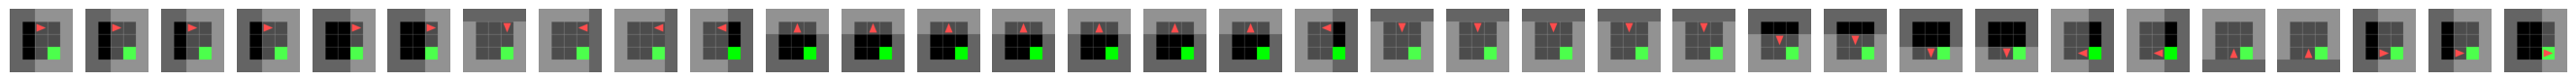

In [56]:
# Show the final path
fig, axes = plt.subplots(1, len(frames), figsize=(len(frames), 5))
for i, frame in enumerate(frames):
    axes[i].imshow(frame)
    axes[i].axis("off")
plt.show()

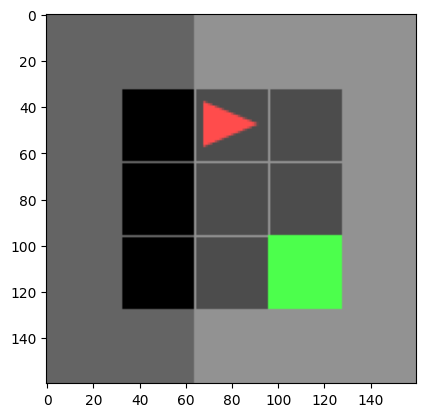

In [ ]:
# Here, we attempt to visualise the frames as an animation

fig, ax = plt.subplots()
im = ax.imshow(frames[0])

def update(frame):
    im.set_array(frame)
    return [im]

ani = animation.FuncAnimation(fig, update, frames=frames, interval=300)

HTML(ani.to_jshtml())

In [20]:
env.action_space

Discrete(7)

Now train an RL agent using `stable-baseline3`


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


C:\Users\sures\AppData\Roaming\Python\Python311\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80.4     |
|    ep_rew_mean     | 0.224    |
| time/              |          |
|    fps             | 365      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80          |
|    ep_rew_mean          | 0.225       |
| time/                   |             |
|    fps                  | 228         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011036133 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.0669     |
|    learning_rate        | 0.

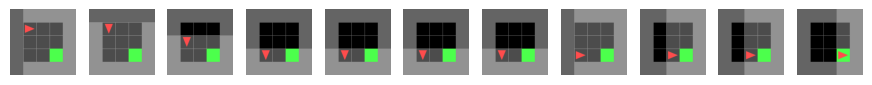

In [37]:
from stable_baselines3 import PPO

# Wrap environment for image-based input
env = ImgObsWrapper(RGBImgPartialObsWrapper(gym.make("MiniGrid-Empty-5x5-v0", render_mode="rgb_array")))

# Initialize and train the agent
model = PPO("CnnPolicy", env, verbose=1)
model.learn(total_timesteps=10_000)

# Test trained agent
obs, info = env.reset()
done = False
frames = []

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    frames.append(env.render())

# Show the trained agent's path
fig, axes = plt.subplots(1, len(frames), figsize=(len(frames), 5))
for i, frame in enumerate(frames):
    axes[i].imshow(frame)
    axes[i].axis("off")
plt.show()
